# M and V methods

### Imports

In [22]:
from pathlib import Path
import numpy as np
import zipfile

from utils.export import *

from models.cart_pendulum import make_cart_pendulum
from models.vehicle_platoon import make_vehicle_platoon

from methods.method_m import solve_m_method
from methods.method_v import solve_v_method

from utils.integrate import integrate_with_lamb0_yielded
from utils.trajectory import *
from utils.metrics import rel_norm

from utils.plotting import plot_result, _resolve_colors, plot_u_errors_overlay


### Output saving settings

In [23]:
run_name = "methods"  # used for filenames

ROOT = find_repo_root()
FIG_DIR, RES_DIR = ensure_out_dirs(ROOT)
print("Repo root:", ROOT)

run_id = make_run_id(run_name)
print("Run id:", run_id)

generated_files: list[Path] = []


Repo root: C:\Users\CristinaÁlvarezYuste\OneDrive - Quantum Mads\Documentos\GitHub\Quantum-assisted-Optimal-Control-examples
Run id: methods_20260118_013445_456917


## 1) Cart Pendulum example

### Editable parameters

In [24]:
# --- Type of instance ---
MODEL_NAME = "cart_pendulum"     

# --- Time horizon and grid ---
T = 10.0
dt = 0.001

# --- Physical and model parameters ---
m = 1.0         # Pendulum mass 
M = 5.0         # Cart mass
L = 2.0         # Pendulum length
g = -10.0       # Gravity
delta = 1.0     # Friction coefficient

# --- Weights for the cost function ---
Q = np.eye(4)                         # State weight matrix
R = np.array([[1e-2]])                # Control weight matrix
H = np.diag([0.0, 10, 50.0, 10.0])    # Terminal state weight matrix

# --- Initial and reference states ---
x_ref = np.array([1.0, 0.0, np.pi, 0.0])         # Reference state
x0    = np.array([-1.0, 0.0, np.pi+0.1, 0.0])    # Initial state


# --- V method size ---
m_grid = 50                     


# --- Output controls ---
save_plots = False
save_results = False
make_zip = False


### Create instance with those parameters

In [25]:
# Instance from LQRModel factory
model = make_cart_pendulum(T=T, dt=dt,m=m, M=M, L=L, g=g, delta=delta, Q=Q, R=R, H=H, x_ref=x_ref, x0=x0)

print("Created", model.name, "with dim =", model.A.shape[0])


Created cart_pendulum with dim = 4


## 1.1) M method

In [26]:
m_res = solve_m_method(model.C, model.H, model.e0, model.T)
print("The condition number for the matrix M which needs to be inverted is cond(M):", f"{m_res.condM:.3e}")

sol_M, E_M, LAM_M, X_M, U_M = integrate_with_lamb0_yielded(
    C=model.C,
    e0=model.e0,
    lamb0=m_res.lamb0,
    T=model.T,
    t_eval=model.t_eval,
    model_name=model.name,
    x_ref=model.x_ref,
    Rinv_BT=model.Rinv_BT,
)
t_M = np.asarray(sol_M.t)

tr_M = make_trajectory_result(
    method="M",
    model=model,
    t=t_M,
    E=E_M,
    LAM=LAM_M,
    X=X_M,
    U=U_M,
    meta={"condM": m_res.condM},
)


The condition number for the matrix M which needs to be inverted is cond(M): 2.032e+11


## 1.2) V method

In [27]:
v_res = solve_v_method(model.C, model.H, model.e0, model.T, m_grid)
print("The condition number for the matrix V which needs to be inverted is cond(V)~", f"{v_res.condV:.3e}")

# No need to integrate with lambda0 yielded because the solution of this methods outputs directly the trajectories
E_V = v_res.E
LAM_V = v_res.LAM
t_V = np.arange(m_grid) * v_res.system.dt # or np.linspace(0, model.T, m_grid)

X_V = x_of_e_cart(E_V, model.x_ref)
U_V = compute_control_from_lam(LAM_V, model.Rinv_BT) 


tr_V = make_trajectory_result(
    method="V",
    model=model,
    t=t_V,
    E=E_V,
    LAM=LAM_V,
    X=X_V,
    U=U_V,
    meta={"condV_est": v_res.condV},
)

The condition number for the matrix V which needs to be inverted is cond(V)~ 1.822e+04


### Comparisons / residuals 

In [28]:
#--- Compare results ---
print("\n--- Comparison of results ---")

# Initial costate difference (relative): ||λ0_V - λ0_M|| / ||λ0_V||
rel_lamb0 = rel_norm(v_res.lamb0, m_res.lamb0)
print(f"rel ||λ0_V - λ0_M||        : {rel_lamb0:.3e}")

# Terminal residuals: ||λ_T - H e_T||
term_M = np.linalg.norm(LAM_M[-1] - model.H @ E_M[-1])
term_V = np.linalg.norm(LAM_V[-1] - model.H @ E_V[-1])
print(f"\nterminal condition mismatch M ||λ_T - H e_T|| : {term_M:.3e}")
print(f"terminal condition mismatch V ||λ_T - H e_T|| : {term_V:.3e}")

# V-method linear system residual: ||V z - rhs||
resV = v_res.system.V @ v_res.z - v_res.system.rhs
print(f"\nV linear residual ||V z - rhs||_2   : {np.linalg.norm(resV):.3e}")
print(f"V linear residual max|V z - rhs|    : {np.max(np.abs(resV)):.3e}")

# M-method linear system residual: ||M λ0 - N e0||
rhsM = m_res.N @ model.e0
resM = m_res.M @ m_res.lamb0 - rhsM
print(f"\nM linear residual ||M λ0 - N e0||_2 : {np.linalg.norm(resM):.3e}")
print(f"M linear residual max|M λ0 - N e0|  : {np.max(np.abs(resM)):.3e}")




--- Comparison of results ---
rel ||λ0_V - λ0_M||        : 1.627e-07

terminal condition mismatch M ||λ_T - H e_T|| : 1.018e+00
terminal condition mismatch V ||λ_T - H e_T|| : 6.061e-20

V linear residual ||V z - rhs||_2   : 2.472e-14
V linear residual max|V z - rhs|    : 1.063e-14

M linear residual ||M λ0 - N e0||_2 : 8.387e-02
M linear residual max|M λ0 - N e0|  : 6.250e-02


## 1.3) Plots

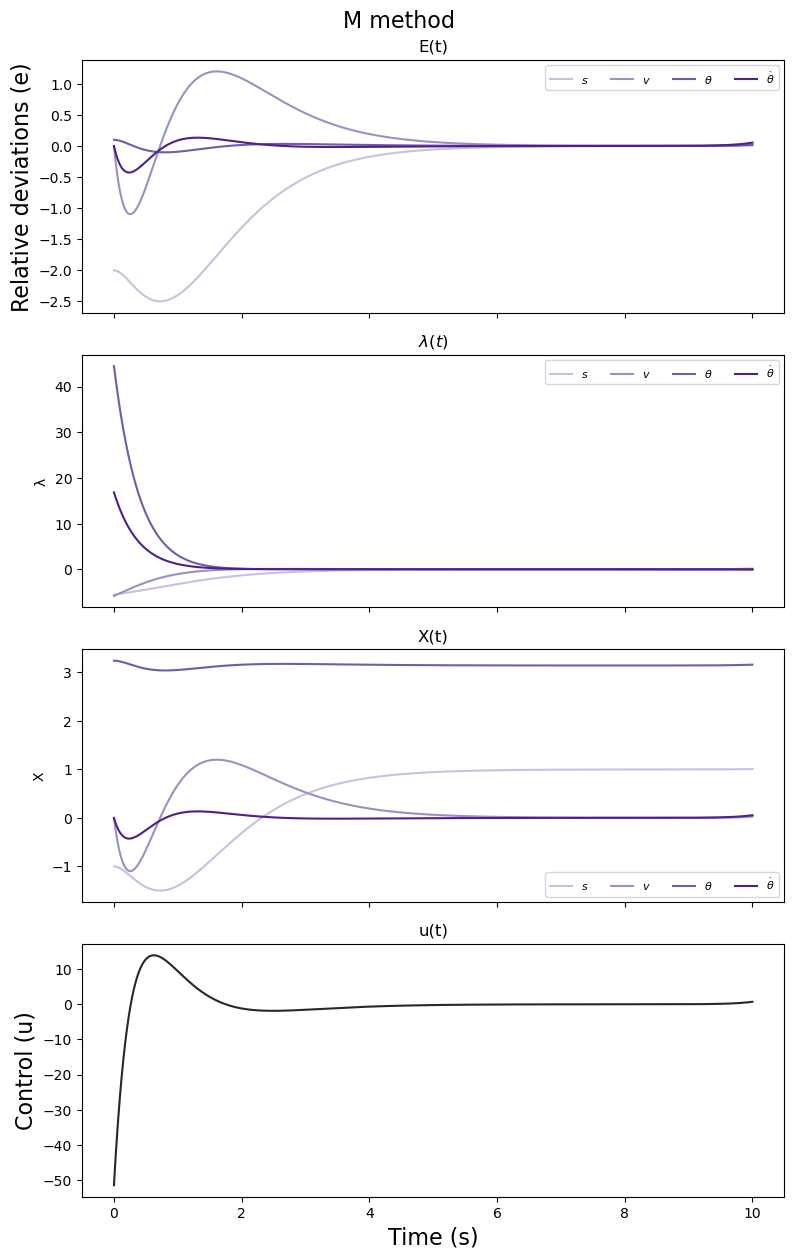

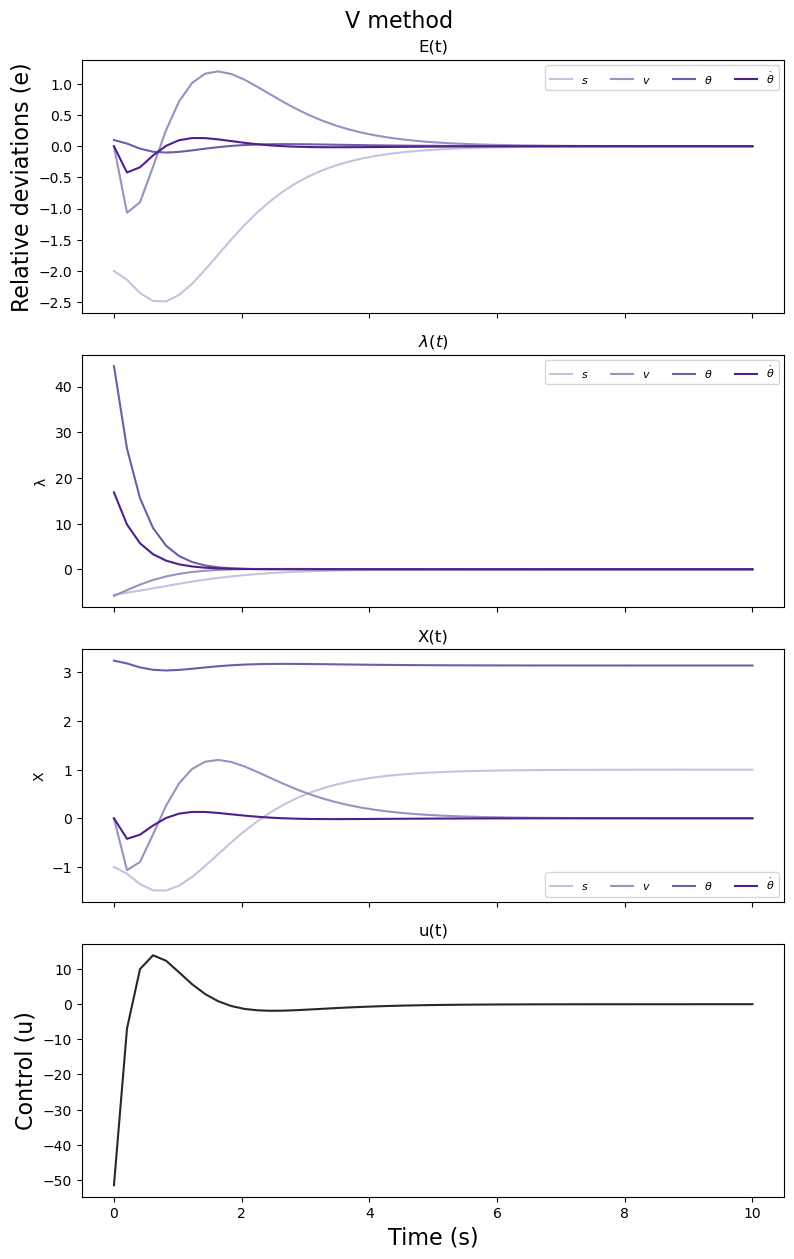

In [29]:
figM, _axsM = plot_result(
    tr_M,
    panels=("E", "LAM", "X", "U"),
    cart_labels=("s", "v", r"\theta", r"\dot{\theta}"),
    title="M method",
    show=True,
)

figV, _axsV = plot_result(
    tr_V,
    panels=("E", "LAM", "X", "U"),
    cart_labels=("s", "v", r"\theta", r"\dot{\theta}"),
    title="V method",
    show=True,
)

# --------- Save plots ----------
if save_plots:
    outM = FIG_DIR / f"{run_id}_M_{tr_M.model_name}.pdf"
    outV = FIG_DIR / f"{run_id}_V_{tr_V.model_name}.pdf"
    figM.savefig(outM, dpi=200, bbox_inches="tight")
    figV.savefig(outV, dpi=200, bbox_inches="tight")
    generated_files += [outM, outV]


# --------- Save results (JSON meta + NPZ arrays) ----------
if save_results:
    meta = {
        "run_id": run_id,
        "model_name": tr_M.model_name,
        "M": {"meta": dict(tr_M.meta)},
        "V": {"meta": dict(tr_V.meta)},
    }

    meta_path = RES_DIR / f"{run_id}_meta.json"
    save_json(meta_path, meta)
    generated_files.append(meta_path)

    npzM = RES_DIR / f"{run_id}_M_traj.npz"
    save_npz(npzM, t=tr_M.t, E=tr_M.E, LAM=tr_M.LAM, X=tr_M.X, U=tr_M.U)
    generated_files.append(npzM)

    npzV = RES_DIR / f"{run_id}_V_traj.npz"
    save_npz(npzV, t=tr_V.t, E=tr_V.E, LAM=tr_V.LAM, X=tr_V.X, U=tr_V.U)
    generated_files.append(npzV)




## 1.4) Save outputs into a single zip file

In [30]:
zip_path = RES_DIR / f"{run_id}_outputs.zip"

if make_zip:
    with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
        for p in generated_files:
            zf.write(p, arcname=str(p.relative_to(ROOT)))
    print("Created:", zip_path)
    try:
        from IPython.display import FileLink, display
        display(FileLink(str(zip_path)))
    except Exception:
        pass
else:
    print("make_zip=False; skipping zip creation")

print("\nGenerated files:")
for p in generated_files:
    print(" -", p)

make_zip=False; skipping zip creation

Generated files:


---

---

## 2) Vehicle platooning example

### Editable parameters

In [31]:
# --- Type of instance ---
MODEL_NAME = "vehicle_platoon"     

# --- Time horizon and grid ---
T = 10.0
dt = 0.001

# --- Physical and model parameters ---
n   = 5            # number of followers
d   = 5.0          # desired spacing [m]
d0  = 60.0         # initial spacing [m]
tau = 0.5          # actuator lag [s]

# ----------------- Single vehicle model ----------------
A0 = np.array([[0.0, 1.0,      0.0],
               [0.0, 0.0,      1.0],
               [0.0, 0.0, -1.0/tau]], dtype=float)  # (3x3)

b0 = np.array([[0.0],
               [0.0],
               [1.0/tau]], dtype=float)             # (3x1)

# LQR weights (per-vehicle)
Q0 = np.diag([1.0, 1.0, 1.0])   # on [spacing error, rel speed, rel accel]
R0 = np.array([[0.5]])          # scalar input weight (control effort)
# Terminal weight (stacked n-followers)
H = np.eye(3*n)

# ----------------- Stacked n-followers model --------------
# initial absolute states (leader + n followers)  length = n+1
s0 = 300.0
v0 = 7.0

s_abs = s0 - np.arange(0, n+1) * d0      # [s0, s0-d0, s0-2d0, ...]
v_abs = np.full(n+1, v0)
a_abs = np.zeros(n+1)

def u0(t): 
    u0 = 200* np.sin(2*t)                  # leader input can be time dependent!
    return u0       




# --- V method size ---
m_grid = 50     



# --- Output controls ---
save_plots = True
save_results = False
make_zip = False


### Create instance with those parameters

In [32]:
# Instance from LQRModel factory
model = make_vehicle_platoon(n=n, d=d, tau=tau, T=T, dt=dt, s_abs=s_abs, v_abs=v_abs, a_abs=a_abs, Q0=Q0, R0=R0, H=H, u0=u0, integrate_leader=True)

print("Created", model.name, "with dim =", model.A.shape[0])

Created vehicle_platoon with dim = 15


## 2.1) M method

In [33]:
m_res = solve_m_method(model.C, model.H, model.e0, model.T)
print("The condition number for the matrix M which needs to be inverted is cond(M):", f"{m_res.condM:.3e}")

sol_M, E_M, LAM_M, X_M, U_M = integrate_with_lamb0_yielded(
    C=model.C,
    e0=model.e0,
    lamb0=m_res.lamb0,
    T=model.T,
    t_eval=model.t_eval,
    model_name=model.name,
    leader_traj=model.leader_traj,       
    d=model.params["d"],                  
    n_followers=model.params["n"],        
    Rinv_BT=model.Rinv_BT,
)
t_M = np.asarray(sol_M.t)

tr_M = make_trajectory_result(
    method="M", model=model, t=t_M, E=E_M, LAM=LAM_M, X=X_M, U=U_M,
    meta={"condM": m_res.condM},
)

The condition number for the matrix M which needs to be inverted is cond(M): 2.389e+12


## 2.2) V method

In [34]:
v_res = solve_v_method(model.C, model.H, model.e0, model.T, m_grid)
print("The condition number for the matrix V which needs to be inverted is cond(V)~", f"{v_res.condV:.3e}")

E_V = v_res.E
LAM_V = v_res.LAM
t_V = np.arange(m_grid) * v_res.system.dt

# reconstrucción coherente en la malla de V:
X0_V = model.leader_at(t_V)            # (m_grid,3)
X_V  = x_of_e_vehicle(E_V, X0_V, d=model.params["d"], n_followers=model.params["n"])
U_V  = compute_control_from_lam(LAM_V, model.Rinv_BT)

tr_V = make_trajectory_result(
    method="V", model=model, t=t_V, E=E_V, LAM=LAM_V, X=X_V, U=U_V,
    meta={"condV_est": v_res.condV},
)

The condition number for the matrix V which needs to be inverted is cond(V)~ 7.586e+01


### Comparisons / residuals 

In [35]:
#--- Compare results ---
print("\n--- Comparison of results ---")

# Initial costate difference (relative): ||λ0_V - λ0_M|| / ||λ0_V||
rel_lamb0 = rel_norm(v_res.lamb0, m_res.lamb0)
print(f"rel ||λ0_V - λ0_M||        : {rel_lamb0:.3e}")

# Terminal residuals: ||λ_T - H e_T||
term_M = np.linalg.norm(LAM_M[-1] - model.H @ E_M[-1])
term_V = np.linalg.norm(LAM_V[-1] - model.H @ E_V[-1])
print(f"\nterminal residual M ||λ_T - H e_T|| : {term_M:.3e}")
print(f"terminal residual V ||λ_T - H e_T|| : {term_V:.3e}")

# V-method linear system residual: ||V z - rhs||
resV = v_res.system.V @ v_res.z - v_res.system.rhs
print(f"\nV linear residual ||V z - rhs||_2   : {np.linalg.norm(resV):.3e}")
print(f"V linear residual max|V z - rhs|    : {np.max(np.abs(resV)):.3e}")

# M-method linear system residual: ||M λ0 - N e0||
rhsM = m_res.N @ model.e0
resM = m_res.M @ m_res.lamb0 - rhsM
print(f"\nM linear residual ||M λ0 - N e0||_2 : {np.linalg.norm(resM):.3e}")
print(f"M linear residual max|M λ0 - N e0|  : {np.max(np.abs(resM)):.3e}")




--- Comparison of results ---
rel ||λ0_V - λ0_M||        : 5.770e-06

terminal residual M ||λ_T - H e_T|| : 1.285e+02
terminal residual V ||λ_T - H e_T|| : 0.000e+00

V linear residual ||V z - rhs||_2   : 4.677e-13
V linear residual max|V z - rhs|    : 1.705e-13

M linear residual ||M λ0 - N e0||_2 : 1.211e+01
M linear residual max|M λ0 - N e0|  : 1.000e+01


## 2.3) Plots

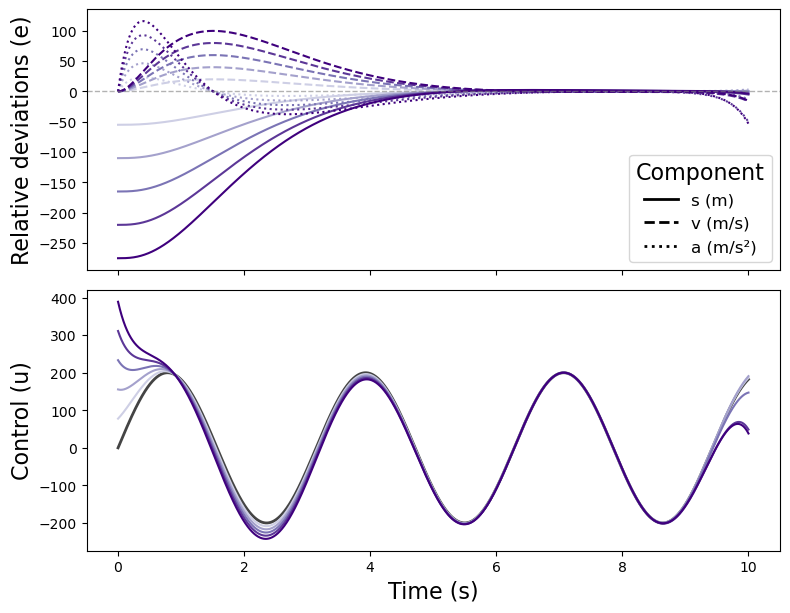

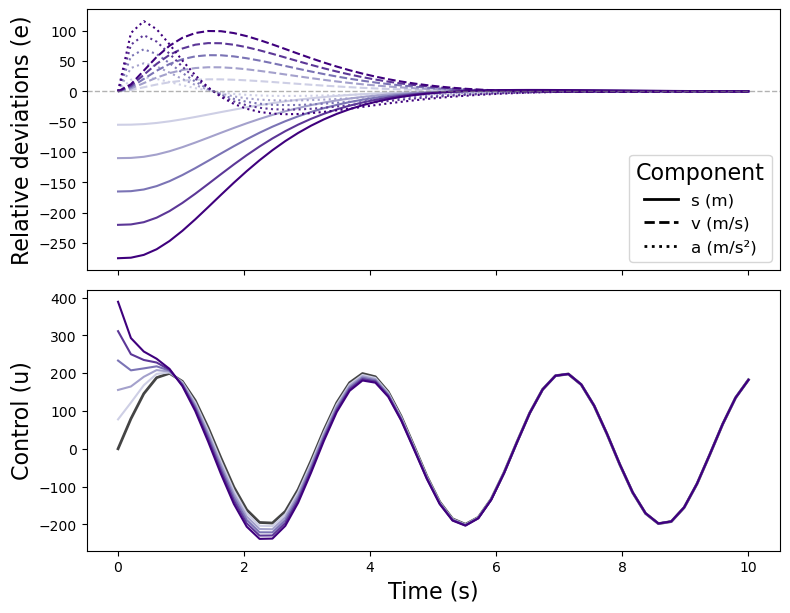

In [36]:

figM, _axsM = plot_result(
    tr_M,
    panels=("E","U"),
    vehicle_overlay_components=True,   # plot each vehicle's component in the same subplot
    all_followers=True,                # plot all followers' components

    include_u0=True,                   # add leader input to followers' inputs
    u0_fun=model.params["u0"],         

    vehicle_u_mode="absolute",         # u_i = u0 + ũ_i
                                       # vehicle_u_mode = "tilde"     
    show=True, 
    
)



figV, _axsV = plot_result(
    tr_V,
    panels=("E","U"),
    vehicle_overlay_components=True,   # plot each vehicle's component in the same subplot
    all_followers=True,                # plot all followers' components

    include_u0=True,                   # add leader input to followers' inputs
    u0_fun=model.params["u0"],         

    vehicle_u_mode="absolute",         # u_i = u0 + ũ_i
                                       # vehicle_u_mode = "tilde"     
    show=True, 
      
)

# --------- Save plots ----------
if save_plots:
    outM = FIG_DIR / f"{run_id}_M_{tr_M.model_name}.pdf"
    outV = FIG_DIR / f"{run_id}_V_{tr_V.model_name}.pdf"
    figM.savefig(outM, dpi=200, bbox_inches="tight")
    figV.savefig(outV, dpi=200, bbox_inches="tight")
    generated_files += [outM, outV]


# --------- Save results (JSON meta + NPZ arrays) ----------
if save_results:
    meta = {
        "run_id": run_id,
        "model_name": tr_M.model_name,
        "M": {"meta": dict(tr_M.meta)},
        "V": {"meta": dict(tr_V.meta)},
    }

    meta_path = RES_DIR / f"{run_id}_meta.json"
    save_json(meta_path, meta)
    generated_files.append(meta_path)

    npzM = RES_DIR / f"{run_id}_M_traj.npz"
    save_npz(npzM, t=tr_M.t, E=tr_M.E, LAM=tr_M.LAM, X=tr_M.X, U=tr_M.U)
    generated_files.append(npzM)

    npzV = RES_DIR / f"{run_id}_V_traj.npz"
    save_npz(npzV, t=tr_V.t, E=tr_V.E, LAM=tr_V.LAM, X=tr_V.X, U=tr_V.U)
    generated_files.append(npzV)

### Compute trajectory from Riccati


In [37]:
from lqr.riccati import *
from utils.riccati_maps import *
import matplotlib.pyplot as plt


# --- Solution via Differential Riccati Equation (DRE) ---
DRE = lqr_gain_dre(
    model.A, model.B, model.Q, model.R,
    T=model.T,
    H_T=model.H,
    t_eval=model.t_eval,  
    method="Radau"
) # Stores P(t) and K(t) time-varying gains and forward time grid


# Simulate closed-loop system with time-varying gain K and initial error e0 (IVP)
t_DRE, E_DRE = simulate_timevarying_gain_piecewise(
    model.A, model.B, DRE.t, DRE.K,
    e0=model.e0,
    method="Radau",
    rtol=1e-8,
    atol=1e-8,
)
assert np.allclose(t_DRE, model.t_eval, DRE.t)

# Riccati maps (Costate, control, state)
LAM_DRE = lam_of_e_dre(E_DRE, DRE.P)
U_DRE   = u_of_e_dre(E_DRE, DRE.K)
X0 = model.leader_at(DRE.t)
X_DRE = x_of_e_vehicle(E_DRE, X0, model.params["d"], n_followers=model.params["n"])

# Trajectory result
tr_DRE = make_trajectory_result(
    method="DRE",
    model=model,
    t=t_DRE,
    E=E_DRE,
    LAM=LAM_DRE,
    X=X_DRE,
    U=U_DRE,
    meta={},
)


In [38]:
print(tr_DRE.U.shape)
print(tr_M.U.shape)
print(tr_V.U.shape)

(10001, 5)
(10001, 5)
(50, 5)


### Compute differnet V trajectories to plot and compare

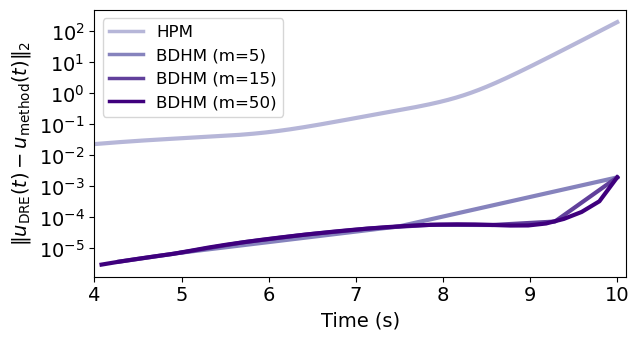

In [39]:

# General instance
model = make_vehicle_platoon(n=n, d=d, tau=tau, T=T, dt=dt, s_abs=s_abs, v_abs=v_abs, a_abs=a_abs, Q0=Q0, R0=R0, H=H, u0=u0, integrate_leader=True)

# V-method with m=5
m_grid = 5
v_res = solve_v_method(model.C, model.H, model.e0, model.T, m_grid)
E_V = v_res.E
LAM_V = v_res.LAM
t_V = np.arange(m_grid) * v_res.system.dt
X0_V = model.leader_at(t_V)            
X_V  = x_of_e_vehicle(E_V, X0_V, d=model.params["d"], n_followers=model.params["n"])
U_V  = compute_control_from_lam(LAM_V, model.Rinv_BT)
tr_V1 = make_trajectory_result(
    method="V", model=model, t=t_V, E=E_V, LAM=LAM_V, X=X_V, U=U_V,
    meta={"condV_est": v_res.condV},
)

# V-method with m=15
m_grid = 15
v_res = solve_v_method(model.C, model.H, model.e0, model.T, m_grid)
E_V = v_res.E
LAM_V = v_res.LAM
t_V = np.arange(m_grid) * v_res.system.dt
X0_V = model.leader_at(t_V)            
X_V  = x_of_e_vehicle(E_V, X0_V, d=model.params["d"], n_followers=model.params["n"])
U_V  = compute_control_from_lam(LAM_V, model.Rinv_BT)
tr_V2 = make_trajectory_result(
    method="V", model=model, t=t_V, E=E_V, LAM=LAM_V, X=X_V, U=U_V,
    meta={"condV_est": v_res.condV},
)

# V-method with m=50
m_grid = 50
v_res = solve_v_method(model.C, model.H, model.e0, model.T, m_grid)
E_V = v_res.E
LAM_V = v_res.LAM
t_V = np.arange(m_grid) * v_res.system.dt
X0_V = model.leader_at(t_V)            
X_V  = x_of_e_vehicle(E_V, X0_V, d=model.params["d"], n_followers=model.params["n"])
U_V  = compute_control_from_lam(LAM_V, model.Rinv_BT)
tr_V3 = make_trajectory_result(
    method="V", model=model, t=t_V, E=E_V, LAM=LAM_V, X=X_V, U=U_V,
    meta={"condV_est": v_res.condV},
)


#--- Plot control errors wrt to Riccati---
fig, ax = plot_u_errors_overlay(
    [tr_M, tr_V1, tr_V2, tr_V3],
    tr_DRE,
    error_type="absolute",
    reduce="norm",
    magnitude=True,
    yscale="symlog",
    symlog_linthresh=1e-10,
    legend="trajectory",
    traj_labels=[
        "HPM",
        "BDHM (m=5)",
        "BDHM (m=15)",
        "BDHM (m=50)",
    ],
    traj_colors="Purples",
    traj_cmap_range=(0.40, 1),
    traj_linestyles=["-"], #["-", "--", ":", "-."],
    t_min=4,
    t_max=10.1,
    fontsize=14,
    linewidth=3.0,
    alpha_norm=1.0,                             
)
plt.show()


# --------- Save plots ----------
if save_plots:
    outMV = FIG_DIR / f"{run_id}_M_V.pdf"
    fig.savefig(outMV, dpi=200, bbox_inches="tight")
    generated_files += [outMV]




## 2.4) Save outputs into a single zip file

In [40]:
zip_path = RES_DIR / f"{run_id}_outputs.zip"

if make_zip:
    with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
        for p in generated_files:
            zf.write(p, arcname=str(p.relative_to(ROOT)))
    print("Created:", zip_path)
    try:
        from IPython.display import FileLink, display
        display(FileLink(str(zip_path)))
    except Exception:
        pass
else:
    print("make_zip=False; skipping zip creation")

print("\nGenerated files:")
for p in generated_files:
    print(" -", p)

make_zip=False; skipping zip creation

Generated files:
 - C:\Users\CristinaÁlvarezYuste\OneDrive - Quantum Mads\Documentos\GitHub\Quantum-assisted-Optimal-Control-examples\figures\methods_20260118_013445_456917_M_vehicle_platoon.pdf
 - C:\Users\CristinaÁlvarezYuste\OneDrive - Quantum Mads\Documentos\GitHub\Quantum-assisted-Optimal-Control-examples\figures\methods_20260118_013445_456917_V_vehicle_platoon.pdf
 - C:\Users\CristinaÁlvarezYuste\OneDrive - Quantum Mads\Documentos\GitHub\Quantum-assisted-Optimal-Control-examples\figures\methods_20260118_013445_456917_M_V.pdf
